In [1]:
import os
import sys

os.environ["CONFIG_PATHS"] = "../configs/small_model.toml,../configs/notebook_overrides.toml"
sys.path.append("../src")

import numpy as np
import torch
from torch import nn
import time
from torch.utils.data import TensorDataset, DataLoader
from display import Display
from configuration import moves_data

Loaded config:  {"development": {"debug_mode": true, "profile": false, "runtime": 36000, "display_logs_in_console": false, "output_directory": "data/"}, "game": {"board_size": 10, "num_moves": 6233, "moves_directory": "../data/moves_10/"}, "network": {"main_body_channels": 64, "value_head_channels": 16, "value_head_flat_layer_width": 64, "policy_head_channels": 64, "residual_blocks": 8}, "architecture": {"gameplay_processes": 6, "coroutines_per_process": 256, "inference_batch_size": 128}, "mcts": {"full_move_probability": 0.2, "full_move_rollouts": 500, "fast_move_rollouts": 100, "ucb_exploration": 1.4, "root_dirichlet_alpha": 0.03, "root_exploration_fraction": 0.25}}


In [2]:
from neural_net import NeuralNet
from training.load_games import load_games

In [62]:
BATCH_SIZE = 64
MOVES = moves_data()

In [63]:
train_data, test_data = load_games("../data/2024-11-11_13-31-42-gasterolichenes/games")

train_dataset = TensorDataset(*train_data)
test_dataset = TensorDataset(*test_data)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

Reserving 262 files for testing.
Loaded 107244 training samples.
Loaded 11910 testing samples.


In [64]:
def _print_losses(value_loss, policy_loss, accuracy=None):
    print("   Avg value loss:  ", value_loss)
    print("   Avg policy loss: ", policy_loss)
    print("   Avg total loss:  ", value_loss + policy_loss)
    if accuracy:
        print("   Accuracy:  ", accuracy)

def _train(dataloader, optimizer, model, value_losses, policy_losses):
    size = len(dataloader.dataset)
    model.train()
    for batch, (occupancies, children_visits, values) in enumerate(dataloader):
        start_time = time.time()

        batch_size = len(occupancies)

        occupancies = occupancies.to("mps")
        children_visits = children_visits.to("mps")
        values = values.to("mps")

        pred_values, pred_children_visits = model(occupancies)
        value_loss = nn.CrossEntropyLoss()(pred_values, values)
        policy_loss = 0.158 * nn.CrossEntropyLoss()(pred_children_visits, children_visits)
        loss = value_loss + policy_loss

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        current = (batch + 1) * batch_size 
        runtime = time.time() - start_time
        print(f"Training [{current:>5d}/{size:>5d}] [{runtime / batch_size:e}s per sample]")
        _print_losses(
            value_loss.item(),
            policy_loss.item(),
        )
    value_losses.append(value_loss.item())
    policy_losses.append(policy_loss.item())

def _test(dataloader, model, value_losses, policy_losses):
    size = len(dataloader.dataset)
    model.eval()

    sum_value_loss, sum_policy_loss = 0.0, 0.0
    correct_winner_count = 0
    correct_stupid_winner_count = 0

    with torch.no_grad():
        for occupancies, children_visits, values in dataloader:
            occupancies = occupancies.to("mps")
            children_visits = children_visits.to("mps")
            values = values.to("mps")

            pred_values, pred_children_visits = model(occupancies)         
            sum_value_loss += nn.CrossEntropyLoss(reduction="sum")(pred_values, values).item()
            sum_policy_loss += 0.158 * nn.CrossEntropyLoss(reduction="sum")(pred_children_visits, children_visits).item()

            pred_values = pred_values.numpy(force=True)
            values = values.numpy(force=True)

            stupid_predicted_winners = np.argmax(np.sum(occupancies.numpy(force=True), axis=(2, 3)), axis=1)
            predicted_winners = np.argmax(pred_values, axis=1)
            predicted_winner_real_scores = values[
                np.arange(len(predicted_winners)),
                predicted_winners,
            ]
            correct_winner_count += np.sum(predicted_winner_real_scores > 0)

            stupid_predicted_winner_real_scores =  values[
                np.arange(len(stupid_predicted_winners)),
                stupid_predicted_winners,
            ]
            correct_stupid_winner_count += np.sum(stupid_predicted_winner_real_scores > 0)

    value_loss = sum_value_loss / size
    policy_loss = sum_policy_loss / size
    accuracy = correct_winner_count / size

    value_losses.append(value_loss)
    policy_losses.append(policy_loss)
    print("Test Error:")
    _print_losses(
        value_loss,
        policy_loss,
    )
    print("Smart accuracy: ", accuracy)
    print("Stupid accuracy: ", correct_stupid_winner_count / size)

In [ ]:
model = NeuralNet().to("mps")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [67]:
epochs = 1
test_value_losses = []
test_policy_losses = []
train_value_losses = []
train_policy_losses = []

try:
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        _train(train_dataloader, optimizer, model, train_value_losses, train_policy_losses)
        _test(test_dataloader, model, test_value_losses, test_policy_losses)
except KeyboardInterrupt:
    print("Training interrupted.")

Epoch 1
-------------------------------
Training [  128/107244] [5.949922e-04s per sample]
   Avg value loss:   1.18314790725708
   Avg policy loss:  0.6476656198501587
   Avg total loss:   1.8308135271072388
Training [  256/107244] [2.274383e-04s per sample]
   Avg value loss:   1.1291937828063965
   Avg policy loss:  0.6641345620155334
   Avg total loss:   1.79332834482193
Training [  384/107244] [2.216939e-04s per sample]
   Avg value loss:   1.1016137599945068
   Avg policy loss:  0.6628749370574951
   Avg total loss:   1.764488697052002
Training [  512/107244] [2.226718e-04s per sample]
   Avg value loss:   1.1522705554962158
   Avg policy loss:  0.6280677318572998
   Avg total loss:   1.7803382873535156
Training [  640/107244] [2.203602e-04s per sample]
   Avg value loss:   1.1879243850708008
   Avg policy loss:  0.6094168424606323
   Avg total loss:   1.797341227531433
Training [  768/107244] [2.140161e-04s per sample]
   Avg value loss:   1.2274730205535889
   Avg policy loss: 

In [66]:
_test(test_dataloader, model, [], [])

Test Error:
   Avg value loss:   1.2244624101445016
   Avg policy loss:  0.688874736737524
   Avg total loss:   1.9133371468820255
Smart accuracy:  0.4673383711167087
Stupid accuracy:  0.4767422334172964


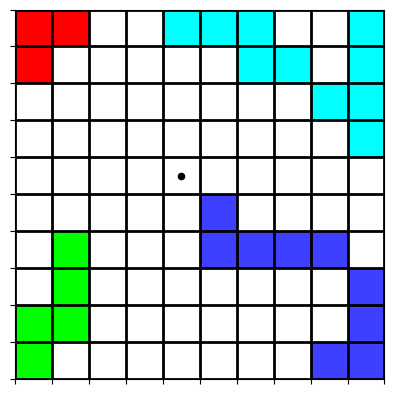

[[0.17109723 0.2796838  0.2755903  0.2736287 ]]
tensor([0., 1., 0., 0.])


In [26]:
boards, policies, values = test_data

# 1000 - pretty good, happy with red, shows green definitely is losing, etc

index = 400
board, policies, values = boards[index], policies[index], values[index]

display = Display(board, overlay_dots=MOVES["new_occupieds"][6188])
display.show()

values_logits_tensor, policy_logits_tensor = model(board.unsqueeze(0).to("mps"))
eval_values = torch.softmax(values_logits_tensor, dim=1).detach().cpu().numpy()
policy_logits = policy_logits_tensor.detach().cpu().numpy()

print(eval_values)
print(values)

array([[9.3196774e-01, 1.7016253e-04, 5.4287713e-02, 1.3574358e-02]],
      dtype=float32)